# Exercise 7) Tidal amplification and damping in estuaries

Upon entering an estuary or tidal basin, the tidal wave from the sea side can experience damping, shoaling and/or reflection, depending on the geometry and friction of the estuary or basin. The development of the tidal amplitude along the estuary depends on the relative contribution of these processes. In this exercise we explore the dependency of the tidal amplitude and of the phase difference between water level elevation and tidal velocity on the shape and frictional properties of an estuary

## Part 1) Funnel shaped estuary
First, we consider a funnel shaped estuary with exponentially decaying width and constant depth (more or less as sketched in figure 1). We can investigate the shoaling or funneling effect using the wave energy flux equation (Green’s Law), which basically states that in absence of friction the amount of (tide averaged) tidal energy in any arbitrary stretch of the estuary is constant. In formulas
\begin{equation}
    \frac{db\overline{E}c}{dx} = 0
\end{equation}
with $db\overline{E}c$ the energy flux through a cross section, $b(x)$ the width, $E(x)$ the energy of the tidal wave per unit area and $c$ the propagation velocity of the tidal wave energy. Next, 

\begin{equation}
    b(x) = b_0\exp{-\beta_x}\\
    \overline{E} = \frac{1}{8}\rho g H^2 \\
    c = \sqrt{gh}
\end{equation}
with

- $\beta=1/L$ the width convergence coefficient, i.e. the inverse of the convergence length $L_b$ 
- $\rho$ the density of water (1000 $kg/m^3$)
- $g$ the gravitational acceleration ($9.81 m/s^2$)
- $H$ the amplitude of the tidal wave
- $h$ the depth
<img src="figs/tidal.png" alt="Drawing" style="float: left" style="width: 200px;"/> 











Figure 1: Tidal estuary planform and longitudinal section (Van Rijn, 2011)

a) Derive an expression for the relation between the tidal amplitude at the entrance of the estuary ($x=0$ m) and any location $x_i$. Use this expression to compute the amplitude of the shoaled tidal wave at respectively 20 and 40 km from the entrance for an estuary with an entrance width $B_0$ of 10 km, a convergence length $L_b$ of 25 km and a constant depth $h$ of 6 m. 

b) Set the parameters to simulate tidal propagation in a funnel shaped estuary with the model below. How do the results compare with the results of a)? If differences exist, explain them.

c) Use the model to investigate the effect of the convergence length, depth and friction coefficient on the tidal amplitude and on the phase difference between water level elevation and velocity. In the literature, hyper-synchronous (with $H>H_0$), hypo-synchronous ($H<H_0$) and synchronous or ideal estuaries ($H≈H_0$) are distinguished. For an estuary with convergence length $L_b$ of 20 km, try to find a ‘synchronous estuary’.

In [1]:
# Imports
import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import time
import os
import pathlib    
import mako.template
# Something very fishy happening if I don't define a plot first.
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
import matplotlib.pyplot as plt
import sys
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
%run config-Ex7.py

In [4]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();

In [5]:
# for i in range(wrapper.get_var_count()):
#     print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

    
bl = wrapper.get_var('bl')
bl_original = bl.copy()
s1_max = wrapper.get_var('s1')
s1_max0 = s1_max.copy()
zk = wrapper.get_var('zk')
zk_original = zk.copy()
global firstupdate

# 

In [6]:

maxsteps = 10000

parameters = [
    {
        "parameter": "B0",
        "description": "Entrance width $B_0$ $[m]$",
        "default": 15
    },    {
        "parameter": "Lb",
        "description": r"Convergence Length $L_b$ $[m]$",
        "default": 50
    },   {
        "parameter": "zk",
        "description": "Depth of bed level $[m]$",
        "default": -10
    },
    
    {
        "parameter": "frcu",
        "description": r"Bottom Roughness (Chézy) $[\sqrt{m}/s]$",
        "default": 70
    },
    
    {
        "parameter": "tidalPeriod",
        "description": r"Tidal period $[min]$",
        "default": 745.0
    },
    
    {
        "parameter": "Tidal amplitude",
        "description": r"Tidal amplitude $[m]$",
        "default": 1.0
    }
    
]

In [7]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=500,
    min=0,
    max=maxsteps,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

items=[]
items2=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))


In [8]:
# Model specific function  #read all the model info
xz = wrapper.get_var('xz')[:]
yz = wrapper.get_var('yz')[:]
indy = np.argsort(yz)[::-1]
newx = xz[indy]

randind = np.random.choice(len(xz), int(len(xz)/5), replace=False)

lX = len(np.unique(xz))
lY = len(np.unique(yz))

firstupdate=False
# wx_set = False
B0_modified=False
x_cs = np.linspace(0,8000,9)


def update_data():
    ucx = wrapper.get_var('ucx')[:]
    ucy = wrapper.get_var('ucy')[:]
    s1 = wrapper.get_var('s1')[:]
    s1_max = s1.copy()
    bl = wrapper.get_var('bl')[:]
    zk = wrapper.get_var('zk')[:]
    B0=np.array(np.float(items[0].value))
    Lb = np.array(np.float(items[1].value))
    B_cs = B0*np.exp(-x_cs/Lb)
    
    if len(data)==0:
        s1_max = s1_max0.copy()
   
        
    if len(data)>1:
        if data[-1]['bl'][0]!=data[-2]['bl'][0]:
            print('writing s1 to model')
            s1 = s1 + bl_original - bl
            wrapper.set_var('s1', s1)
        s1_max = np.maximum(data[-1]['s1'], data[-1]['s1_max'])
          
    
    s1 = wrapper.get_var('s1')[:]

    data.append(dict({
        "time": wrapper.get_current_time(),
        "ucx": ucx.copy(), 
        "ucy": ucy.copy(), 
        "bl" : bl.copy(),
        "s1" :s1.copy(),
        "s1_max": s1_max.copy(),
        "B0" : B0,
        "Lb" : Lb,
        "B_cs" : B_cs   
        
    }))

    slider.max = len(data)
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()



In [9]:
# simulation_dir = pathlib.Path('.') / '..' / 'Estuary_new'
# template = simulation_dir / 'sealev.bc.template'

template = mdufiletemplate
print(template)
# def callback(template, *args, **kwargs):
#     kwargs = {
#         item.description: float(item.value) 
#         for item 
#         in items2
#     }
#     # open old file
#     mako_template = mako.template.Template(filename=str(template.absolute()))
#     # fill in template
#     result = mako_template.render(**kwargs)
#     # write to new file 
#     path = simulation_dir / 'sealev.bc'
#     with path.open('w') as f:
#         f.write(result)

# change_param2 = lambda x: callback(template=template)



# for item in items2:
#     item.observe(change_param2, names='value')

/mnt/d/PROJECTS/hydrodynamics-course/paotm-cluster/notebooks/7_Tidal/Models/ttt.mdu.template


In [10]:
# Standard functions for button widgets #DONT CHANGE!
dostop = False

def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    
    if(data[-1]["time"] != wrapper.get_current_time()):
    
            
        update_data()
        firstupdate=False
      

def start_loop(n):
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()): #check if your last ts is the same ts as model
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    settings.disabled = True
    nsteps.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    nsteps.disabled = False
    for i in items:
        i.disabled = False
    dostop = True


def change_param_nonwrapper(v):
#     global value_of_v
#     global B0
#     global Lb
#     global B0_modified
#     global Lb_modified
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "" or v.value == "-":
        return
    try:
        float(v.value)
        
        new_par = v.value
#         print('in the try loop now', v.value)
        value_of_v = v.value

        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par)
#         if v.placeholder=='B0':
#             B0=np.float(value_of_v)
#             B0_modified=True
#         if v.placeholder=='Lb':
#             Lb=np.float(value_of_v)
            
        
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
    
    
def change_param(v): #dont touch
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "" or v.value == "-":
        return
    try:
        float(v.value)
        
        
        
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        
        if v.placeholder == 'zk': 
            wrapper.set_var_slice('zk', [1], [len(new_par)], new_par) 
#             settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
            return
        
        wrapper.set_var(v.placeholder, new_par)
        
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    
       
        


    
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)
        
        

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])

        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    slider.value = 0
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


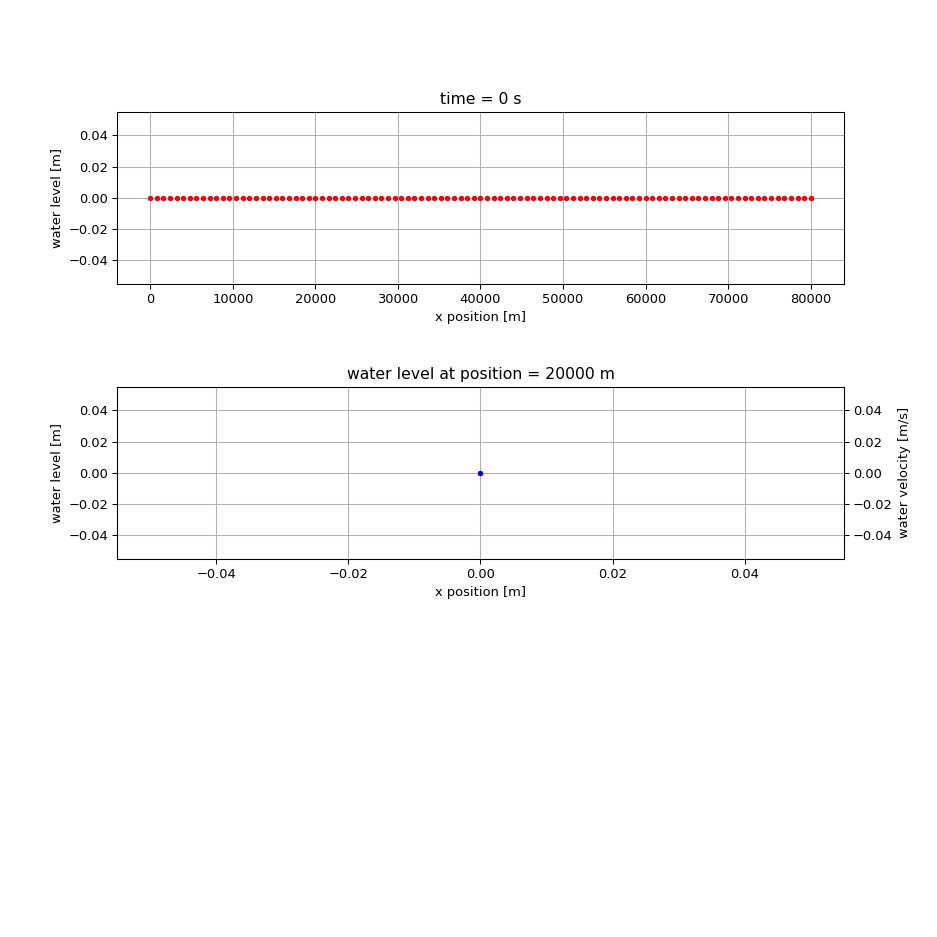

In [11]:

# set plot size
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)

Xslice = 30
# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)
timestep = 0

def set_plot(change):
    
#     x = np.linspace(0,len(data[0]['s1']),len(data[0]['s1']),'.')
    x = wrapper.get_var('xz')[1:-1]
    x_q = wrapper.get_var('xz')[26]
    t = change['new']
    timelist.append(data[t]['time'])
    wllist.append(data[t]['s1'][26])
    wvlist.append(data[t]['ucx'][26])
    miny = np.min(data[t]['s1'])
    maxy = np.max(data[t]['s1_max'])
    
    
    wl_line.set_data(x,data[t]['s1'][1:-1])
    wl_linemax.set_data(x, data[t]['s1_max'][1:-1])
    ax0.set_ylim([miny-0.1,maxy+0.1])
    ax0.set_title('time = %i s' %int(t*120))
    
    minx = 0.0
    maxx = data[t]['time']
    tp = t
    wl_line_q.set_data(timelist,wllist)
    wv_line_q.set_data(timelist,wvlist)
    ax1.set_xlim([minx-10,maxx+10])
    
    miny = min(wllist)
    maxy = max(wllist)
    minyv = min(wvlist)
    maxyv = max(wvlist)
    ax1.set_ylim([miny-1,maxy+1])
    ax1b.set_ylim([minyv-0.5,maxyv+0.5])
    fig.canvas.draw()

slider.observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    if i.placeholder in ['B0', 'Lb']:
        if i.placeholder=='B0':B0_modified=True
        change_param_nonwrapper(i)
        i.observe(change_param_nonwrapper, names='value')   
    else:
        change_param(i)
        i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))

fig = plt.figure()
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((3, 2), (1, 0), colspan=2)


ax1b = ax1.twinx()
display(player)
x = wrapper.get_var('xz')[1:-1]
# x = np.linspace(0,len(data[0]['s1']),len(data[0]['s1']))
ax0.set_xlabel('x position [m]')
ax0.set_ylabel('water level [m]')
ax0.set_title('time = %i s' %int(0))
wl_line, = ax0.plot(x, data[0]['s1'][1:-1],'.')
wl_linemax, = ax0.plot(x, data[0]['s1_max'][1:-1],'r.')

ax0.grid()

timelist = []
timelist.append(data[0]['time'])
wllist = []
wllist.append(data[0]['s1'][26])
wvlist = []
wvlist.append(data[0]['ucx'][26])
x_q = wrapper.get_var('xz')[26]

wl_line_q, = ax1.plot(timelist,wllist,'k.')
wv_line_q, = ax1b.plot(timelist,wvlist,'b.')
ax1.set_xlabel('x position [m]')
ax1.set_ylabel('water level [m]')
ax1b.set_ylabel('water velocity [m/s]')
ax1.set_title('water level at position = %i m' %int(x_q))
ax1.grid()
fig.subplots_adjust(wspace=1.0, hspace=0.6)
plt.draw()

In [12]:
# print(len(data[0]['s1'])) 
# x = np.linspace(0,103,103)
# print(len(x))
# print(np.min(data[0]['s1']))

In [13]:
# print(len(data[0]['ucx']))

In [14]:
# print(wrapper.get_var('xz')[26])

In [15]:
# print(max(wllist))

In [16]:
# print(data[1]['s1'])
# print(data[10]['s1_max'])

